## Notebook Intentions

The United States spends a larger share of its Gross Domestic Product (GDP) on health care than any other major industrialized country. To address high health care costs in this country, policymakers need to understand how those costs are distributed across types of services, different payers and by selected characteristics of the population.

This notebook presents estimates of the percentage of persons with health care expenses by type of service, and mean and median expense per person with an expense by age and insurance status for the U.S. civilian noninstitutionalized population over the past 10 years (2008-2018). All expenditure metrics have been inflated to reflect their expected 2018 values.

## Structure

    1) Expenditures by Source - Displays the percentage of the population with ANY health care expenses across time. Stratifies by age and source
    
    2) Expenditures Metrics by Source - Displays the mean and median expenditures of the population with ANY health care expenses across time. Stratifies by age and source.
    
    3) Expenditures Metrics by Insurance - Displays the mean and median expenditures of the population with ANY health care expenses across time. Stratifies by age and insurance type.
    
## Findings 



1) Expenditures by Source
   

    The proportion of people with expenses varied widely by type of service, with large proportions having expenses for ambulatory services 78.1% in 2018 and prescribed medicines 62.6% in 2008 and much smaller proportions having expenses for home health care and other medical services 17.9% in 2012, and hospital inpatient services 6.3% in 2015. 

    In particular 2018 was a year where multiple age groups and service categories had higher than usual proportions of people with expenses. The Under 65 and All Ages had the highest values for Any Services, Ambulatory Services and Dental Services. All age group had the highest values for Home Health Care and Other Medical Services and Equipment.
    
2) Expenditures Metrics by Source
    
    The mean total expense per person for those with some health care expenses over the decade has remained relatively stable averaging at $5,903. Among specific health care service categories, the mean expense per person who had expenses of that type ranged from $19,806 for hospital inpatient services to $774 for dental services. The mean total expenses for persons age 65 and older with some expenses ($11,403) was more than twice the amount for persons under age 65 ($4,833).

    Adults age 65 and older had larger mean expenses in the following service categories compared to persons under age 65 for all services excluding hospital inpatient services for which the difference in means between these age groups was not significant. 

    Focusing on annual expenses per person we found that in 2018 the Under 65 group had a significantly higher mean value for Any Services ($5,741). The Over 65 group had a significantly higher mean value for Dental Services ($1,135). Additionaly The All Ages group had a significantly higher mean value for Dental Services ($873).
    
    Median expenses were substantially lower than mean expenses, among health care service categories, because a relatively small proportion of persons account for a large proportion of expenses.

    The overall median total expense per person with expenses was $1,517, and ranged across service categories from $10,993 for hospital inpatient services to less than $400 for prescribed medicines, dental services, and home health care and other medical services and supplies ($327, $281, and $310, respectively). Median expenses per person with any expense of that type were consistently higher for the elderly across all service categories when compared with persons under age 65, except for Hospital Inpatient expenses.

    Focusing on annual expenses per person we found that in 2018 the Under 65 and All Ages groups had a significantly higher median value for Any Services ($1,410 and $1,850  respectively). Additionally those same groups had a significantly higher median value for Home Health Care and Other Medical Services and Equipment ($338 and $379  respectively).
    
3) Expenditures Metrics by Insurance

    Average annual health care expenses varied by age and type of health insurance coverage. Persons under age 65 with expenses had a mean total expense of $4,833 and a median total expense of $1,174, while those 65 years and older had a mean total expense of $11,403 and a median total expense of $5,145.

    Among persons under age 65 with expenses, mean and median expenses had a significant peak in 2018 for those with private insurance. Among persons over age 65 with expenses, median expenses had  a significant peak in 2018 for those with medicare and private insurance. 

In [203]:
import os
from os.path import expanduser

import sys
sys.path.append(os.path.join(expanduser("~"), "meps", "meps_dev"))

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "meps_db.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import django
django.setup();

import textwrap

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from textwrap import wrap

from meps_db.components.reference import DATA_FILES_YEARS
from meps_db.analysis.expenses import ExpensesAnalyzer



In [209]:
# desired order of services
services = [
    "Any Services", 
    "Hospital Inpatient", 
    "Ambulatory",
    "Prescribed Medicines", 
    "Dental Services",
    "Home Health Care and Other Medical Services and Equipment", 
]

sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12, "axes.ticksize": 12}) 

In [206]:
# helpers
def identify_outliers_by_age_service(df, field, z_threshold=2.5):
    """ Takes a dataframe, a field to evalute and a z threshold. Filters on a service and an age group. Identifies
    if any members of the field are statistically different from the rest of the group. Prints the outliers. """
    
    outliers = pd.DataFrame()
    for service in services:
        for age_group in ["All Ages", "Under 65", "Over 65"]:
            df_slice = df.loc[(df["age_group"] == age_group) & (df["services"]==service)].copy()
            df_slice["z_score"] = np.abs(stats.zscore(df_slice[field]))
            
            outliers = pd.concat([outliers, df_slice.loc[(df_slice["z_score"]>2.5)]])
                
    display(outliers)

def identify_differences_in_age_groups(df, field, p_threshold=0.05):
    """ Takes a dataframe, a field to evalute and a p score. Generates a series for each service type and for each
    age group. Compares the series across ages groups to identify significant differences. """
    
    sig_differences = []
    for service in services:
        df_under_65 = df.loc[(df["age_group"] == "Under 65") & (df["services"]==service)].copy()
        df_over_65 = df.loc[(df["age_group"] == "Over 65") & (df["services"]==service)].copy()

        # common p values is a artifact of sample size
        ks_stats = stats.ks_2samp(df_under_65["mean"], df_over_65["mean"])
        if ks_stats.pvalue <= p_threshold:
            sig_differences.append(
                {
                    "service": service,
                    "p_value":  ks_stats.pvalue
                }
            )
    display(pd.DataFrame(sig_differences))
    
def identify_outliers_by_age_insurance(df, field, z_threshold=2.5):
    """ Takes a dataframe, a field to evalute and a z threshold. Filters on an insurance type and an age group. 
    Identifies if any members of the field are statistically different from the rest of the group. Prints the 
    outliers. """
    
    outliers = pd.DataFrame()
    for insurance in ["private", "public", "uninsured", "medicare_only", "medicare_private", "medicare_public"]:
        for age_group in ["All Ages", "Under 65", "Over 65"]:
            df_slice = df.loc[(df["age_group"] == age_group) & (df["insurance_status"]==insurance)].copy()
            df_slice["z_score"] = np.abs(stats.zscore(df_slice["median"]))

            outliers = pd.concat([outliers, df_slice.loc[(df_slice["z_score"]>2.5)]])

    display(outliers)


In [207]:
# Initializer analyzer
expenses_analyzer = ExpensesAnalyzer(years = DATA_FILES_YEARS[:11])

### Expenditures by Source

Percent of the U.S. civilian noninstitutionalized population, who had some expenses for health care which includes hospital inpatient, ambulatory services (office-based visits, hospital outpatient care, and emergency room services), prescribed medicines, dental services, and home health care and other medical services and equipment 

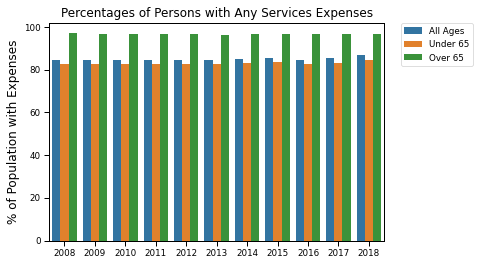

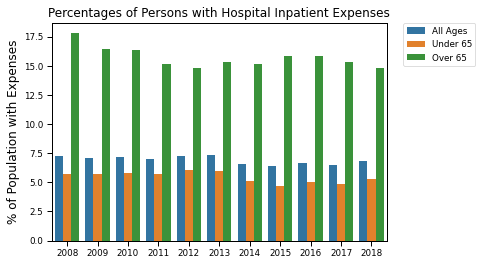

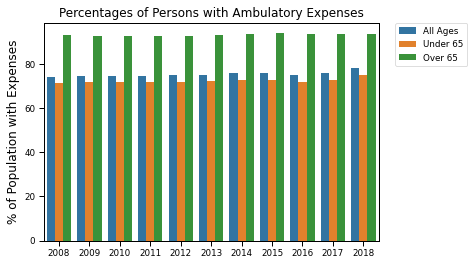

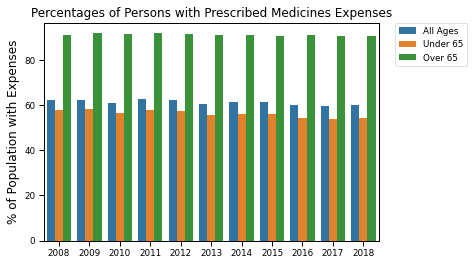

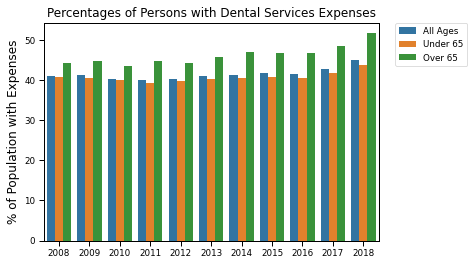

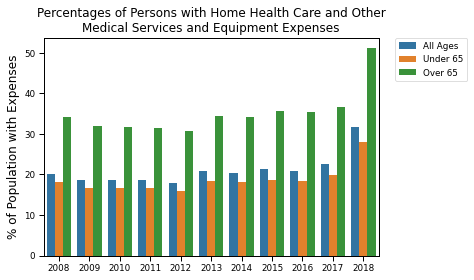

In [211]:
any_exp_by_source_df = pd.DataFrame(expenses_analyzer.calculate_any_expenses())

for service in services:
    #plt.figure(figsize=(15,8))
    ax = sns.barplot(
        x="year", 
        y="pct_with_expenses", 
        hue="age_group", 
        data=any_exp_by_source_df.loc[(any_exp_by_source_df["services"]==service)],
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title("\n".join(wrap(f"Percentages of Persons with {service} Expenses", 60)))
    ax.set(xlabel=None)
    ax.set(ylabel="% of Population with Expenses")
    plt.savefig(f"pct_expenses/pct_expenses_{service.lower().replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()
    

In [137]:
# range of expenditures for all ages
for service in services:
    service_all_age_exp = any_exp_by_source_df.loc[
        (any_exp_by_source_df["age_group"] == "All Ages")  & (any_exp_by_source_df["services"]==service)
    ]
    
    print(f"{service}:")
    print(f"    Min: {min(service_all_age_exp['pct_with_expenses'])}")
    print(f"    Max: {max(service_all_age_exp['pct_with_expenses'])}")

Any Services:
    Min: 84.39837925835961
    Max: 86.67029781705851
Hospital Inpatient:
    Min: 6.371463204681088
    Max: 7.307682100112108
Ambulatory:
    Min: 74.30295377645017
    Max: 78.14348361144731
Prescribed Medicines:
    Min: 59.821073798199976
    Max: 62.672518920243114
Dental Services:
    Min: 40.167053177731944
    Max: 45.193579510669174
Home Health Care and Other Medical Services and Equipment:
    Min: 17.974791432430106
    Max: 31.78671971164811


In [140]:
identify_outliers_by_age_service(df=any_exp_by_source_df, field="pct_with_expenses", z_threshold=2.5)

,year,services,age_group,pct_with_expenses,z_score
0,2018,Any Services,All Ages,86.670298,2.748743
1,2018,Any Services,Under 65,84.695106,2.840301
92,2013,Any Services,Over 65,96.007932,2.932835
6,2018,Ambulatory,All Ages,78.143484,2.555844
7,2018,Ambulatory,Under 65,75.066936,2.724288
12,2018,Dental Services,All Ages,45.193580,2.667459
13,2018,Dental Services,Under 65,43.918706,2.693911
15,2018,Home Health Care and Other Medical Services an...,All Ages,31.786720,2.944730
16,2018,Home Health Care and Other Medical Services an...,Under 65,28.012061,2.961474
17,2018,Home Health Care and Other Medical Services an...,Over 65,51.106457,2.970905


### Expenditures Metrics by Source

Mean and Median annual expenditures of the U.S. civilian noninstitutionalized population, who had some expenses for health care which includes hospital inpatient, ambulatory services (office-based visits, hospital outpatient care, and emergency room services), prescribed medicines, dental services, and home health care and other medical services and equipment 

In [146]:
expense_metrics_by_source_df = pd.DataFrame(expenses_analyzer.calculate_expenses_metrics())

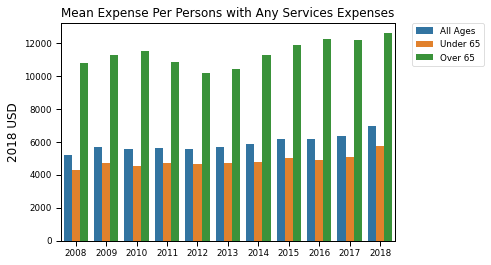

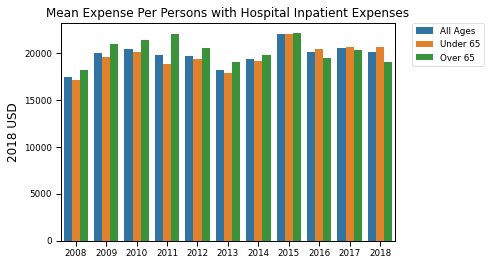

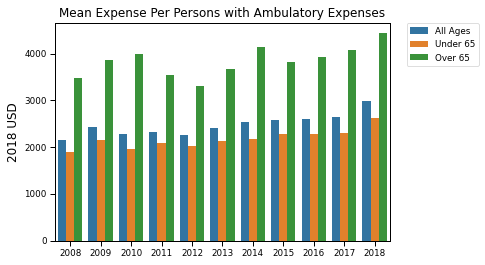

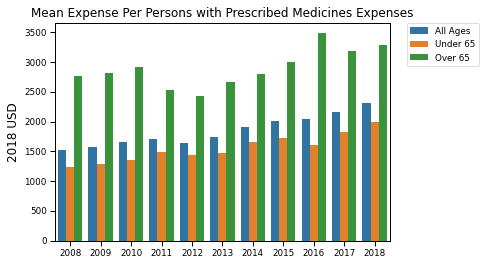

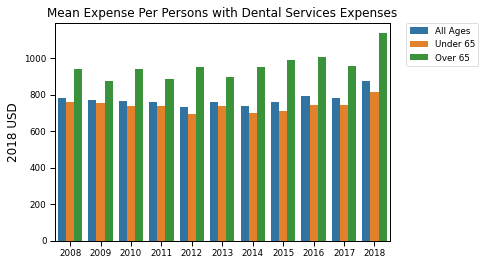

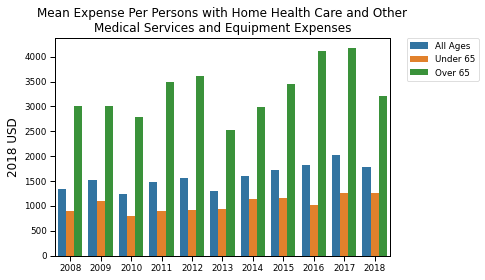

In [224]:
for service in services:
    #plt.figure(figsize=(15,8))
    ax = sns.barplot(
        x="year", 
        y="mean", 
        hue="age_group", 
        data=expense_metrics_by_source_df.loc[(expense_metrics_by_source_df["services"]==service)]
    )
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title("\n".join(wrap(f"Mean Expense Per Persons with {service} Expenses", 60)))
    ax.set(xlabel=None)
    ax.set(ylabel=f"{DATA_FILES_YEARS[0]} USD")
    plt.savefig(f"mean_expenses/{service.lower().replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()

In [148]:
# identify statistically significant outliers
identify_outliers_by_age_service(df=expense_metrics_by_source_df, field="mean", z_threshold=2.5)

,year,services,age_group,mean,median,z_score
1,2018,Any Services,Under 65,5741.554044,1410.0,2.550685
12,2018,Dental Services,All Ages,873.912604,300.0,2.801879
14,2018,Dental Services,Over 65,1135.214512,400.0,2.597085


In [149]:
# identify statistically significant difference in age groups
identify_differences_in_age_groups(df=expense_metrics_by_source_df, field="mean", p_threshold=0.05)

,service,p_value
0,Any Services,0.000003
1,Ambulatory,0.000003
2,Prescribed Medicines,0.000003
3,Dental Services,0.000003
4,Home Health Care and Other Medical Services an...,0.000003


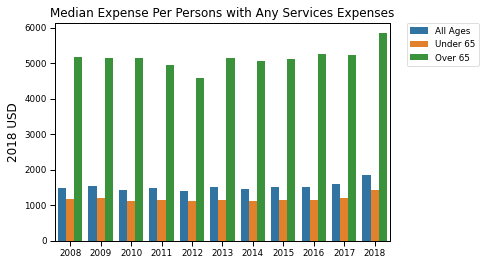

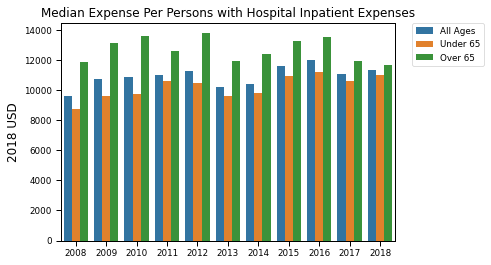

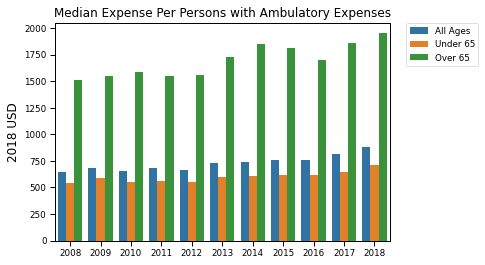

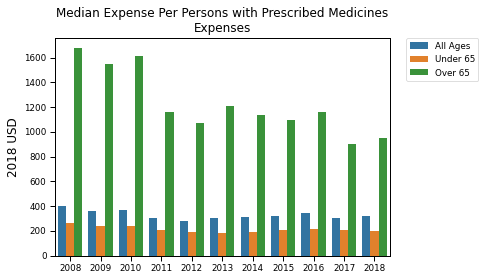

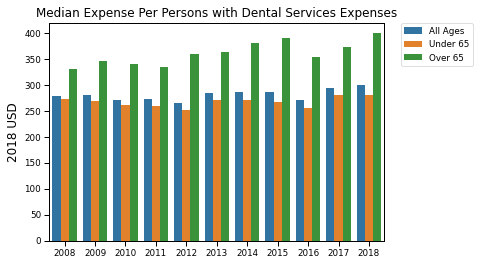

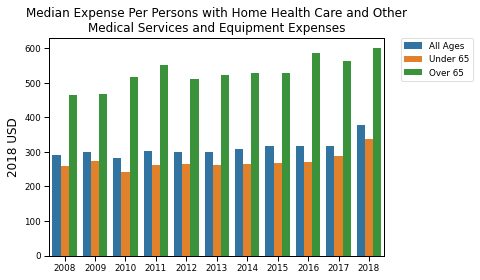

In [231]:
for service in services:
    #plt.figure(figsize=(15,8))
    ax = sns.barplot(
        x="year", 
        y="median", 
        hue="age_group", 
        data=expense_metrics_by_source_df.loc[(expense_metrics_by_source_df["services"]==service)]
    )
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title("\n".join(wrap(f"Median Expense Per Persons with {service} Expenses", 60)))
    ax.set(xlabel=None)
    ax.set(ylabel=f"{DATA_FILES_YEARS[0]} USD")
    plt.savefig(f"median_expenses/{service.lower().replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()

In [150]:
# identify statistically significant outliers
identify_outliers_by_age_service(df=expense_metrics_by_source_df, field="median", z_threshold=2.5)

,year,services,age_group,mean,median,z_score
0,2018,Any Services,All Ages,6995.631273,1850.0,2.890968
1,2018,Any Services,Under 65,5741.554044,1410.0,2.928242
15,2018,Home Health Care and Other Medical Services an...,All Ages,1775.511302,379.0,2.838981
16,2018,Home Health Care and Other Medical Services an...,Under 65,1261.925666,338.0,2.808240


In [151]:
# identify statistically significant difference in age groups
identify_differences_in_age_groups(df=expense_metrics_by_source_df, field="median", p_threshold=0.05)

,service,p_value
0,Any Services,0.000003
1,Ambulatory,0.000003
2,Prescribed Medicines,0.000003
3,Dental Services,0.000003
4,Home Health Care and Other Medical Services an...,0.000003


### Expenditures Metrics by Insurance 

Mean and Median expenditures of the U.S. civilian noninstitutionalized population, who had some expenses for health care. Expense estimates include amounts paid by individuals, private insurance, Medicare, Medicaid, and other payment sources.

Health insurance status

Individuals under age 65 were classified in the following three insurance categories, based on household responses to health insurance status questions:

    Any private health insurance: Individuals who, at any time during the year, had insurance that provides coverage for hospital and physician care (other than Medicare, Medicaid/CHIP, or other public hospital/physician coverage) were classified as having private insurance. Coverage by TRICARE (Armed Forces-related coverage) was also included as private health insurance. Insurance that provides coverage for a single service only, such as dental or vision coverage, was not included.
    
    Public coverage only: Individuals were considered to have public coverage only if they met both of the following criteria: 1) they were not covered by private insurance at any time during the year, 2) they were covered by any of the following public programs at any point during the year: Medicare, Medicaid/CHIP, or other public hospital/physician coverage.
    
    Uninsured: The uninsured were defined as people not covered by private hospital/physician insurance, Medicare, TRICARE, Medicaid/CHIP, or other public hospital/physician programs at any time during the entire year or period of eligibility for the survey.
    
    
Individuals age 65 and older were classified into the following three insurance categories:

    Medicare and private insurance: This category includes persons classified as Medicare beneficiaries and covered by Medicare and a supplementary private policy.
    
    Medicare and other public insurance: This category includes persons classified as Medicare beneficiaries who met both of the following criteria: 1) They were not covered by private insurance at any point during the year, 2) They were covered by one of the following public programs at any point during the year: Medicaid, other public hospital/physician coverage.
    
    Medicare only: This category includes persons classified as Medicare beneficiaries but not classified as Medicare and private insurance or as Medicare and other public insurance. This group includes persons who were enrolled in Medicare Advantage (Part C) and persons who had traditional Medicare fee-for-service coverage only.

In [167]:
expense_metrics_by_insurance_df = pd.DataFrame(expenses_analyzer.calculate_expenses_metrics_by_insurance())

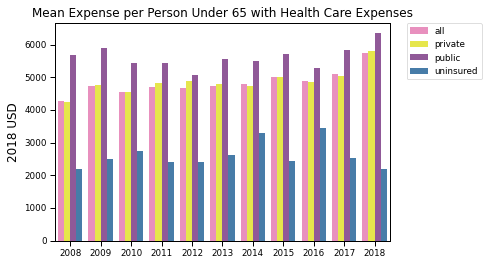

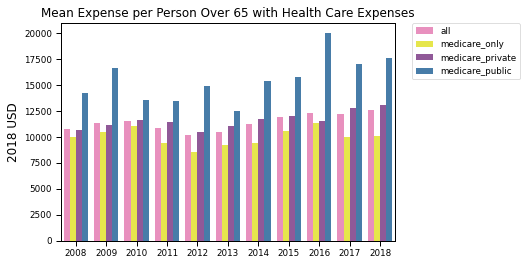

In [264]:

for age_group in ["Under 65", "Over 65"]:

    #plt.figure(figsize=(15,8))
    ax = sns.barplot(
        x="year", 
        y="mean", 
        hue="insurance_status", 
        data=expense_metrics_by_insurance_df.loc[(expense_metrics_by_insurance_df["age_group"]==age_group)],
        palette="Set1_r"
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title("\n".join(wrap(f"Mean Expense per Person {age_group} with Health Care Expenses", 60)))
    ax.set(xlabel=None)
    ax.set(ylabel=f"{DATA_FILES_YEARS[0]} USD")
    plt.savefig(f"insurance_expenses/mean_{age_group.lower().replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()

In [184]:
identify_outliers_by_age_insurance(df=expense_metrics_by_insurance_df, field="mean", z_threshold=2.5)

,year,insurance_status,age_group,mean,median,z_score
1,2018,private,Under 65,5802.189441,1572.0,2.663764
6,2018,medicare_private,Over 65,13097.031277,6226.0,2.910702


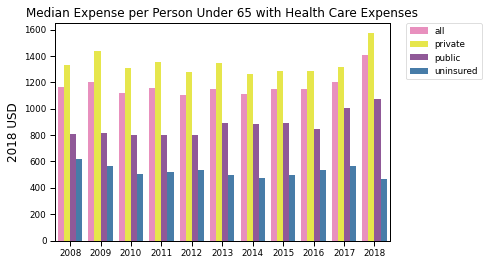

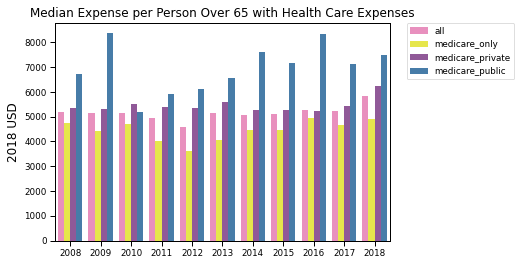

In [265]:
for age_group in ["Under 65", "Over 65"]:
    
    #plt.figure(figsize=(15,8))
    ax = sns.barplot(
        x="year", 
        y="median", 
        hue="insurance_status", 
        data=expense_metrics_by_insurance_df.loc[(expense_metrics_by_insurance_df["age_group"]==age_group)],
        palette="Set1_r"
    )
   
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title("\n".join(wrap(f"Median Expense per Person {age_group} with Health Care Expenses", 60)))
    ax.set(xlabel=None)
    ax.set(ylabel=f"{DATA_FILES_YEARS[0]} USD")
    plt.savefig(f"insurance_expenses/median_{age_group.lower().replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()

In [183]:
identify_outliers_by_age_insurance(df=expense_metrics_by_insurance_df, field="median", z_threshold=2.5)

,year,insurance_status,age_group,mean,median,z_score
1,2018,private,Under 65,5802.189441,1572.0,2.663764
6,2018,medicare_private,Over 65,13097.031277,6226.0,2.910702
